In [4]:
## FAR STAFF: As noted in the read me file, please either PIP install or CONDA install
## these libraries onto your python environment:
## pandas, rocketpy, numpy, math

## This code should automatically pull the thrust and mass flow data from the csv files
## included in the zip

## The very bottom prints all the most important values

In [5]:
import pandas as pd
import sys
import os
import math

# Get the current working directory
current_directory = os.getcwd()
# Get the parent directory
parent_directory = os.path.dirname(current_directory)
if parent_directory not in sys.path:
    sys.path.append(parent_directory)
import pythonExcelPull



#Must have openpyxl installed in python environment, separately from the pandas install! Pandas will call on this
# Read the Excel file
df = pd.read_excel('../MasterParameters.xlsx')

# List of variables to pull from the Excel file
variables_to_pull = ['heightPayload',
                     'heightNoseCone',
                     'heightMainBay',
                     'heightAvBay',
                     'heightDrogueBay',
                     'heightCoupler3',
                     'heightOx',
                     'heightFuel',
                     'heightCoupler2',
                     'heightCoupler1',
                     'heightEngine',
                     'OD',
                     'tankThick'
]

# Creating an object to store excel variables
class Parameters:
    pass
ex = Parameters()

# Storing excel variables in object
for variable in variables_to_pull:
    value = pythonExcelPull.pythonExcelPull(df, variable)
    setattr(ex, variable, value)
    

In [6]:
#Just some code to test that excel pull worked

print(ex.OD)
print(ex.tankThick)

# Should output 6 and 0.25

6
0.25


In [7]:
# Important things to note
#   1. All units are metric (kg, N, etc)

#INPUT VARIABLES
#eventually, tie the variables between python and matlab together



#Height of engine + stage prop hardware (start of recovery)
heightRecoveryImperial = ex.heightDrogueBay + ex.heightAvBay + ex.heightMainBay + ex.heightNoseCone
heightStagePropImperial = ex.heightCoupler1 + ex.heightOx + ex.heightCoupler2 + ex.heightFuel + ex.heightCoupler3
heightVehicleImperial = ex.heightEngine + heightStagePropImperial + heightRecoveryImperial
print(heightVehicleImperial)

#CONVERSION PARAMETERS:
in2m = 0.0254
psi2pa = 6894.76
lbf2N = 4.44822
lbm2kg = 0.45359237 #for converting pounds to kg

#GEOMETRIC PARAMETERS OF VEHICLE: METRIC!!
heightPayload = ex.heightPayload * in2m
heightNoseCone= ex.heightNoseCone * in2m
heightMainBay = ex.heightMainBay * in2m
heightAvBay = ex.heightAvBay * in2m
heightDrogueBay = ex.heightDrogueBay * in2m
heightCoupler3 = ex.heightCoupler3 * in2m
heightFuel = ex.heightFuel * in2m
heightCoupler2 = ex.heightCoupler2 * in2m
heightOx = ex.heightOx * in2m
heightCoupler1 = ex.heightCoupler1 * in2m
heightEngine = ex.heightEngine * in2m
diameter = ex.OD * in2m

heightRecovery = heightRecoveryImperial * in2m
heightStageProp = heightStagePropImperial * in2m
heightVehicle = heightVehicleImperial * in2m

#TANK PROPERTIES
tankODImperial = ex.OD
tankIDImperial = ex.OD - (2*ex.tankThick)
tankOuterAreaImperial = (math.pi/4)*tankODImperial**2
tankInnerAreaImperial = (math.pi/4)*tankIDImperial**2
tankDensityImperial = 0.098 #lb/in^3... assumed aluminum


#MOTOR VARIABLES
nozzlePosition = 0 #Will be important so nozzlePosition = motorPosition... sets Rocket and Motor coord zeros the same


#COMPUTED INPUT VARIABLES
radius = diameter / 2

#CSV Files
## thrust
oxTankMassLiq = "../TheEngine/V1.0/oxTankMassLiq"
oxTankMassVap = "../TheEngine/V1.0/oxTankMassVap"
fuelTankMassLiq = "../TheEngine/V1.0/fuelTankMassLiq"
fuelTankMassVap = "../TheEngine/V1.0/fuelTankMassVap"
enginePerformance = "../TheEngine/Regen Solver/ThrustCurve.csv"
powerOnDrag = "./dragCurve.csv"
powerOffDrag = powerOnDrag


#READING SOME VALUES FROM CSV FILES
dataFrame = pd.read_csv(oxTankMassLiq)
timeRun = dataFrame.iloc[-1, 0] #Pulling last time-step

print(timeRun)




119.69726415640002
3.075


In [8]:
from rocketpy import CylindricalTank, Fluid, MassBasedTank

## This section sets the geometry of each prop tank + defines the mass properties of each tank (mass, mass flow, and COG) with respect to time

## Critical Assumptions:
#   1. Duration and Leftover Mass: Mass flow stops when quality of one tank reaches 100%... future solvers may want to solve until both tanks are completely empy of liq and vap phases

## Critical Unknowns:
#   1. COG Calcs: How each prop tank's phase solves it's own COG with volume flucturations
#   2. Discretization: Currently we didn't explicitely define discretization. Defaults to 100. Unsure how this impacts our solver

#1: GEOMETRY OF TANKS
oxTankGeometry = CylindricalTank(radius, heightOx, spherical_caps=False)
fuelTankGeometry = CylindricalTank(radius, heightFuel, spherical_caps=False)

#2: MASS and COG variations in time
# Center of mass calculations for liquid and vapor phases within each tank are still not completeley understood
# Initial density of liquid and gas phase of nitrous and ethane given. ~Incompressible for liquid phases, but density of vapor phase changes drastically as liquid phase is expelled.
    #It is assumed that the COM calcs within each tank accounts for this

#2a: Density of nitrous and ethane at 293K (room temp)
oxidizer_liq = Fluid(name="N2O_l", density=786.25)
oxidizer_gas = Fluid(name="N2O_g", density=157.19)
fuel_liq = Fluid(name="ethane_l", density=339.66)
fuel_gas = Fluid(name="ethane_g", density=85.7)



#Be careful, default 100 discretization may bite us in the butt
oxTank = MassBasedTank(
    name = "Nitrous Oxide Run Tank",
    geometry = oxTankGeometry,
    liquid = oxidizer_liq,
    gas = oxidizer_gas,
    liquid_mass = oxTankMassLiq,
    gas_mass = oxTankMassVap,
    flux_time = timeRun
)

fuelTank = MassBasedTank(
    name = "Ethane Run Tank",
    geometry = fuelTankGeometry,
    liquid = fuel_liq,
    gas = fuel_gas,
    liquid_mass = fuelTankMassLiq,
    gas_mass = fuelTankMassVap,
    flux_time = timeRun
)

#3: PLOT
#oxTank.fluid_mass.plot()
##oxTank.center_of_mass.plot()

#fuelTank.fluid_mass.plot()
#fuelTank.center_of_mass.plot()

In [9]:
#THIS SECTION WILL CALCULATE THE VEHICLE WEIGHT AND COM: Dry + No Engine

#Recovery & Payload: Relative to bottom of Recovery
massPartialRecoverySystemImperial = 17.07 #Everything above prop tanks (recovery), excluding payload
massPayloadImperial = 7.5
comPartialRecoverSystemImperial = heightRecoveryImperial/2
comPayloadImperial = ex.heightDrogueBay + ex.heightAvBay + ex.heightMainBay + (ex.heightPayload/2)

massRecoverySystemsImperial = massPartialRecoverySystemImperial + massPayloadImperial
comRecoverySystemsImperial = ((massPartialRecoverySystemImperial * comPartialRecoverSystemImperial) + (massPayloadImperial * comPayloadImperial)) / massRecoverySystemsImperial
comRecoverySystemsImperial = comRecoverySystemsImperial + heightStagePropImperial + ex.heightEngine #Setting relative to rocket coordinate system

#Stage Propulsion: Relative to bottom of stage propulsion (above engine)
#TANKS
massOxTankDryImperial = tankDensityImperial * ex.heightOx * (tankOuterAreaImperial - tankInnerAreaImperial)
massFuelTankDryImperial = tankDensityImperial * ex.heightFuel * (tankOuterAreaImperial - tankInnerAreaImperial)
comOxTankDryImperial = ex.heightCoupler1 + (ex.heightOx/2)
comFuelTankDryImperial = ex.heightCoupler1 + ex.heightOx + ex.heightCoupler2 + (ex.heightFuel/2)

massTanksDryImperial = massOxTankDryImperial + massFuelTankDryImperial
comTanksDryImperial = ((massOxTankDryImperial * comOxTankDryImperial) + (massFuelTankDryImperial * comFuelTankDryImperial)) / massTanksDryImperial

#STAGE PROP HARDWARE
massPartialStagePropHardwareImperial = 19.2 #Guess for all valves + tubes + bulkheads + etc
comPartialStagePropHardwareImperial = heightStagePropImperial / 2 #Assume halfway

#TANKS + STAGE PROP HARDWARE
massStagePropImperial = massTanksDryImperial + massPartialStagePropHardwareImperial
comStagePropImperial = ((massTanksDryImperial * comTanksDryImperial) + (massPartialStagePropHardwareImperial * comPartialStagePropHardwareImperial)) / massStagePropImperial
comStagePropImperial = comStagePropImperial + ex.heightEngine #Setting relative to rocket coordinate system

#Vehicle Net Dry Mass
massVehicleDryNoMotorImperial = massRecoverySystemsImperial + massStagePropImperial
comVehicleDryNoMotorImperial = ((massRecoverySystemsImperial * comRecoverySystemsImperial) + (massStagePropImperial * comStagePropImperial)) / massVehicleDryNoMotorImperial

#Conversion to SI
massVehicleDryNoMotor = massVehicleDryNoMotorImperial * lbm2kg
comVehicleDryNoMotor = comVehicleDryNoMotorImperial * in2m

massPayload = massPayloadImperial * lbm2kg
comOxTank = (comOxTankDryImperial + ex.heightEngine) * (in2m)
comFuelTank = (comFuelTankDryImperial + ex.heightEngine) * (in2m)

In [10]:
from rocketpy import LiquidMotor, Motor

#This section describes liquid motor parameters

## Critical Assumptions:
#   1. dry_mass: Weight of the thruster unit (chamber body, nozzle, injector). Does not include tanks!!
#   2. dry_mass: random value for now (4.5kg which is 10lbs)
#   3. Nozzle_position: Same distance away as end of rocket. This will set coordinate system of motor & rocket to be the same.
#   4. engine center_of_mass: For now, just half of the estimated engine height
#   5. nozzle radius: For now, nozzle radius is just the same as vehicle radius

## Critical Unknowns:
#   1. Inertia Tensor: Ignore off-diagonal tensor elements for now. 
#       Use default diagonal elements in example... but in future we 
#       can predict as thick wall cylinder or eq in https://en.wikipedia.org/wiki/List_of_moments_of_inertia  
#   2. Nozzle Radius: Unsure the point of this parameter. Not used within liq motor files.
#   3. Center_of_dry_mass_position: Need to come back after estimating size of engine
#   4. Tank Position: Just random values for now



#1. DEFINE ENGINE
theEngine = LiquidMotor(
    thrust_source = enginePerformance,
    dry_mass = 7.5,
    dry_inertia = (0.125, 0.125, 0.002),
    nozzle_radius = diameter/2,
    center_of_dry_mass_position = heightEngine/2,
    nozzle_position = nozzlePosition,
    burn_time = timeRun,
    reshape_thrust_curve = False,
    interpolation_method = "linear",
    coordinate_system_orientation = "nozzle_to_combustion_chamber"
)

#2. ADD TANKS + POSITION OF TANKS RELATIVE TO ROCKET REFERENCE FRAME
theEngine.add_tank(tank=oxTank, position = comOxTank)
theEngine.add_tank(tank=fuelTank, position = comFuelTank)

#3. INFO AND PLOTS
#theEngine.all_info()

#4. EXPORT ENG for FAR OUT
#Motor.export_eng(self='theEngine', file_name='theEngine.eng', motor_name='theEngine')

c:\Users\jacke\anaconda3\envs\ProjectLiquid\Lib\site-packages\rocketpy\motors\motor.py:918: UserWarning: burn_time argument (0, 3.075) is out of thrust source time range. Using thrust_source boundary times instead: (0, 3.07) s.
If you want to change the burn out time of the curve please use the 'reshape_thrust_curve' argument.
  warnings.warn(


In [11]:
#theEngine.all_info()


In [12]:
from rocketpy import Rocket

#This section describes the geometry and aerodynamic properties of vehicle

## Critical Assumptions:
#   1. Power_off_drag and Power_on_drag: Use default for now. Assume = for now.
#   2. Inertia: Plugged in default off RocketPy for now
#   3. Bluffness (for nose): Ignored
#   4. Nose Cone Kind: ogive (most popular in rocketry, but conic may be easier to manuf). Revisit
#   5. Fins: Everything. Revisit
#   6: Tail: None, for now
#   7: railButtons: all of its values

## Critical Unknowns:
#   1. Power_off_drag and Power_on_drag: Compare using RASAero and/or OpenRocket
#   2. Inertia: Unknown
#   3. Bluffness (for nose): "Ratio between the radius of the circle on the tip or the ogive and the radiusof the base on the ogive" idek what that means
#   4. Lift and Drag: General ineptitude with drag and lift calcs done on the backend
#   5. General Aerosurface: How do all the elements interact? How is the bulk rocket body considered? etc.


#This section describes rocket parameters
theRocket = Rocket(
    radius = radius,
    mass = massVehicleDryNoMotor,
    center_of_mass_without_motor = comVehicleDryNoMotor,
    inertia = (6.321, 6.321, 0.034),
    power_off_drag = powerOffDrag,
    power_on_drag = powerOnDrag,
    coordinate_system_orientation = "tail_to_nose"
)
theRocket.add_motor(theEngine, position = nozzlePosition) #Set to nozzlePosition so origin of both is the same... this one has the problem

#Adding Aerodynamic Surfaces
nose_cone = theRocket.add_nose(
    length=heightNoseCone, kind="ogive", position=heightVehicle
)

fin_set = theRocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.1905,
    tip_chord=0.0762,
    span=0.1397,
    position=heightEngine,
)

railButtons = theRocket.set_rail_buttons(
    upper_button_position=heightVehicle * (1/2),
    lower_button_position=heightVehicle * (1/10),
    angular_position=45
)

#Assuming no tail, for now

#tail = theRocket.add_tail(
    #top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
#)

#PLOTS
#theRocket.power_off_drag.plot()

In [13]:
#This section deals with parachutes

#Rest parachutes list if previous iterations had been run... I had issues with .append adding duplicates
if theRocket.parachutes:
    theRocket.parachutes.clear()

#Assumed values until product is found
Cd = 0.97
diamDrogueImperial = 48
diamMainImperial = 168

diamDrogue = diamDrogueImperial * in2m
diamMain = diamMainImperial * in2m

areaDrogue = (math.pi/4)*diamDrogue**2
areaMain = (math.pi/4)*diamMain**2

effectiveAreaDrogue = Cd * areaDrogue
effectiveAreaMain = Cd * areaMain

mainTriggerImperialFeet = 2000 #ft
mainTrigger = (mainTriggerImperialFeet * 12) * in2m

parachuteLag = 0

drogue = theRocket.add_parachute(
    name="Drogue",
    cd_s=effectiveAreaDrogue,
    trigger="apogee",
    sampling_rate=105,
    lag=parachuteLag,
    
)

main = theRocket.add_parachute(
    name="Main",
    cd_s=effectiveAreaMain,
    trigger=mainTrigger,
    sampling_rate=105,
    lag=parachuteLag,
)


In [14]:
#Environmental Information

from rocketpy import Environment, Flight

env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)


import datetime
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
) #Hour given in UTC time

env.set_atmospheric_model(type="Forecast", file="GFS")



Inertia Details

Rocket Mass: 26.016 kg (without motor)
Rocket Dry Mass: 33.516 kg (with unloaded motor)
Rocket Loaded Mass: 40.919 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 17.271 kg*m2
Rocket Inertia (with unloaded motor) 22: 17.271 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.036 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.07619999999999999 m
Rocket Frontal Area: 0.018241 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.305 m
Rocket Center of Dry Mass - Nozzle Exit: 1.236 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.465 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.084 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 7.246/rad

Center of Pressure

Nose

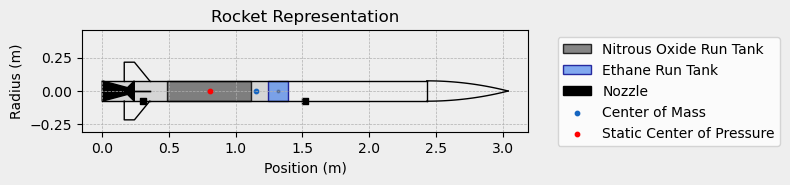


Mass Plots
----------------------------------------


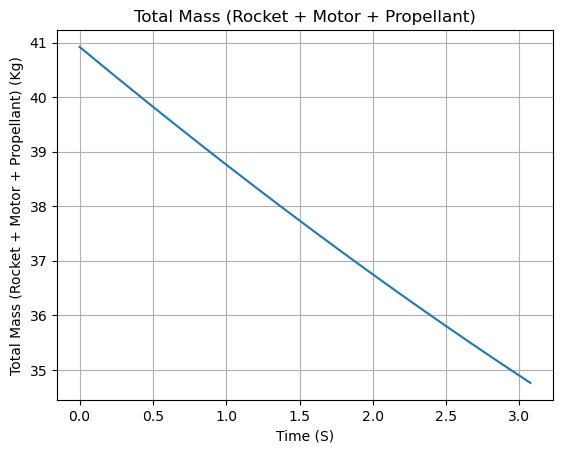

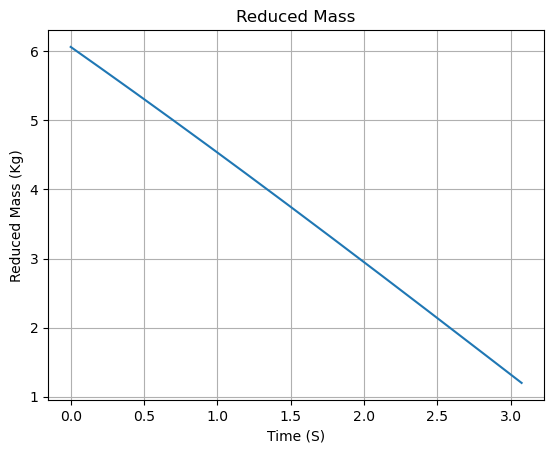


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


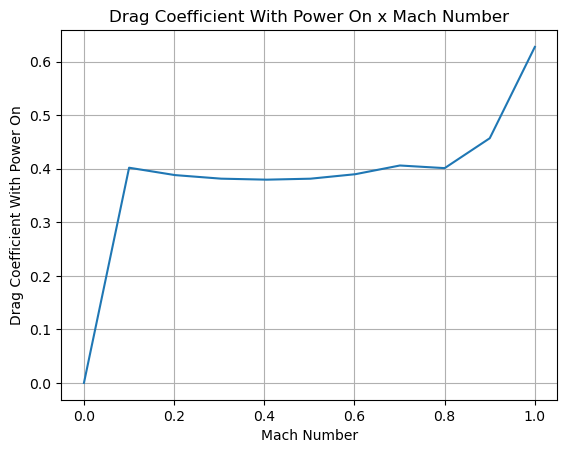

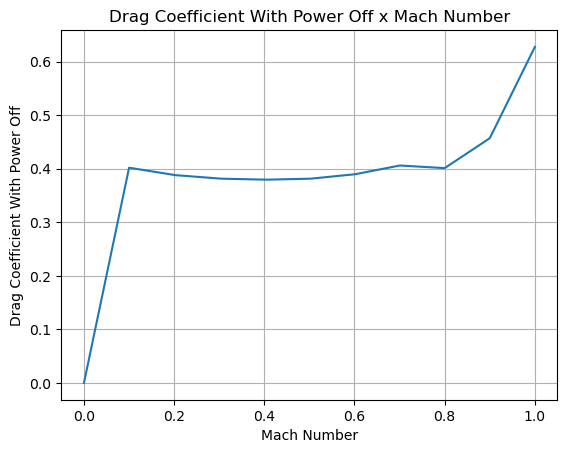


Stability Plots
--------------------


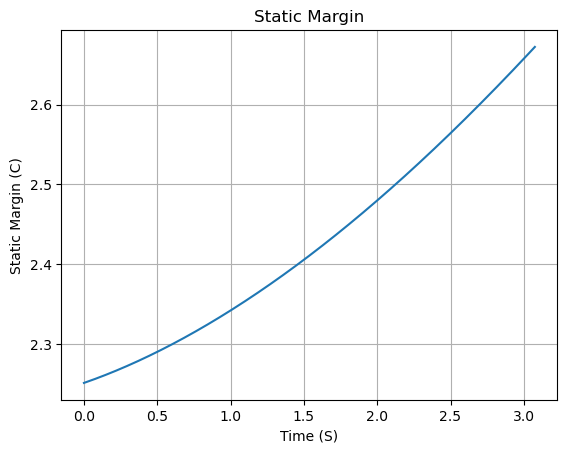

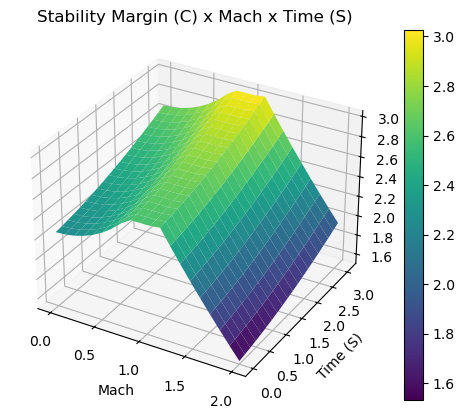


Thrust-to-Weight Plot
----------------------------------------


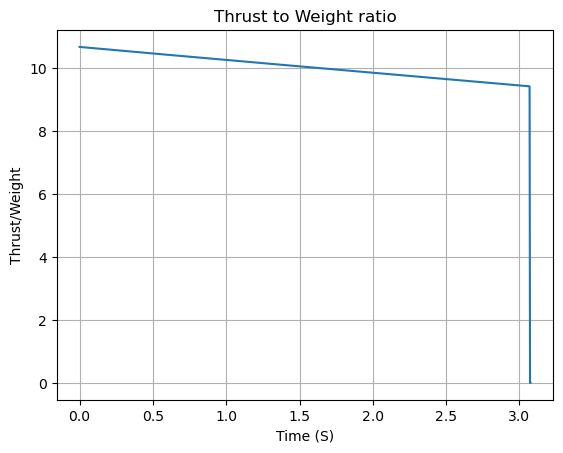

In [15]:
theRocket.all_info()

In [16]:
##IMPORTANT: AT some point we need to introduce an interrupt in case static margin is below zero. Else, the whole model crashes

rail_lengthImperialFeet = 20
rail_length2 = (rail_lengthImperialFeet * 12) * in2m

launchAngle = 5

test_flight = Flight(
    rocket=theRocket, environment=env, rail_length=rail_length2, inclination=90-launchAngle, heading=0
) 


#test_flight.all_info()


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.67 m/s
Lateral Surface Wind Speed: 0.76 m/s


Launch Rail

Launch Rail Length: 6.096  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.311 s
Rail Departure Velocity: 29.319 m/s
Rail Departure Stability Margin: 2.277 c
Rail Departure Angle of Attack: 1.976°
Rail Departure Thrust-Weight Ratio: 10.535
Rail Departure Reynolds Number: 2.781e+05


Burn out State

Burn out time: 3.075 s
Altitude at burn out: 420.830 m (AGL)
Rocket velocity at burn out: 264.224 m/s
Freestream velocity at burn out: 264.225 m/s
Mach Number at burn out: 0.796
Kinetic energy at burn o

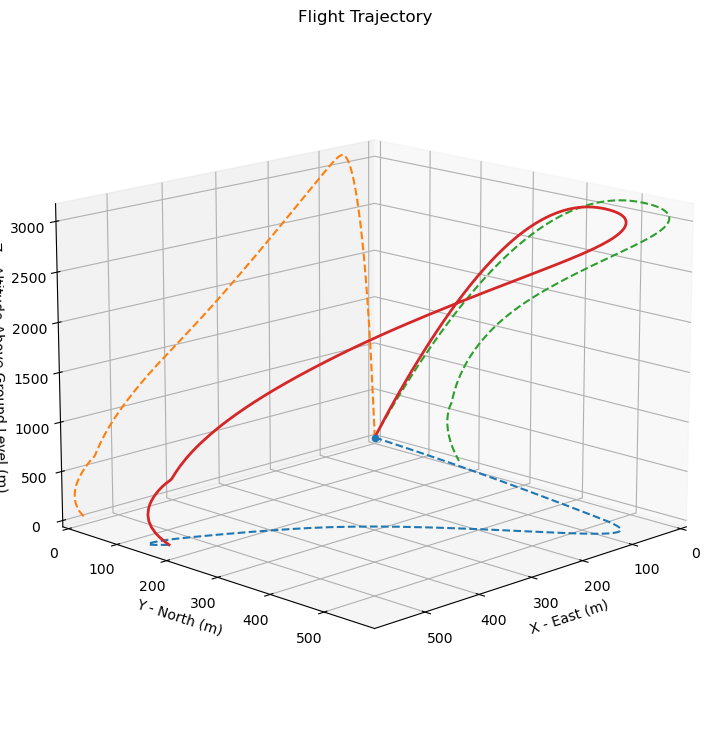



Trajectory Kinematic Plots



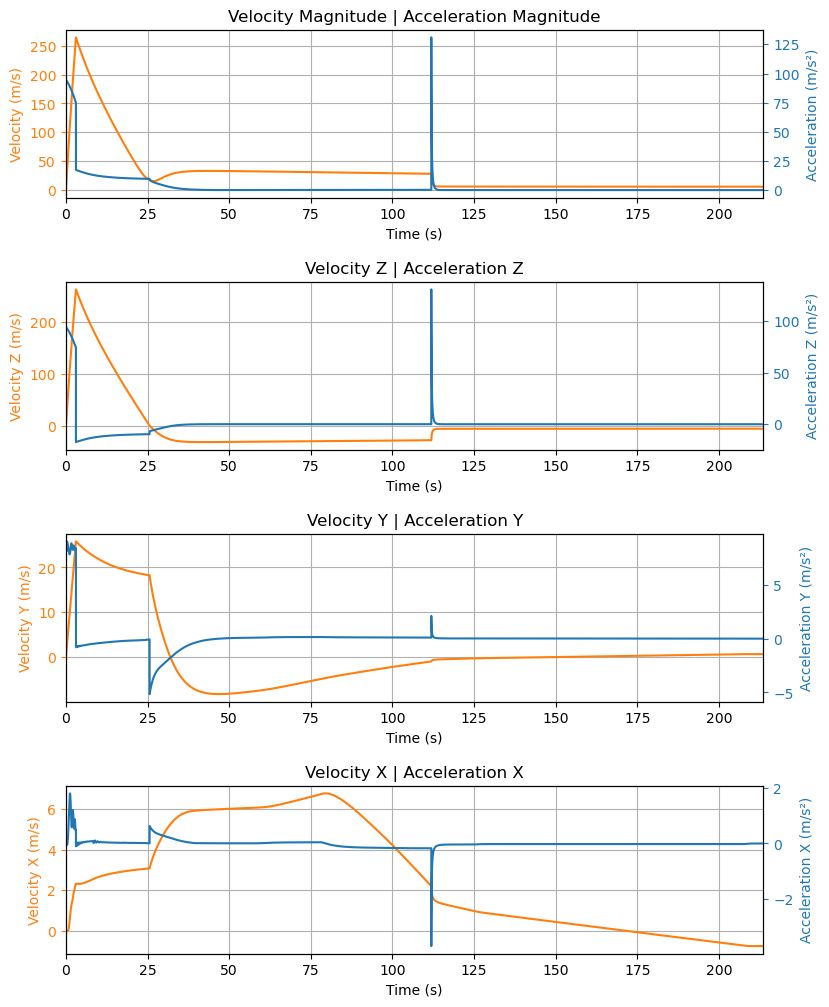



Angular Position Plots



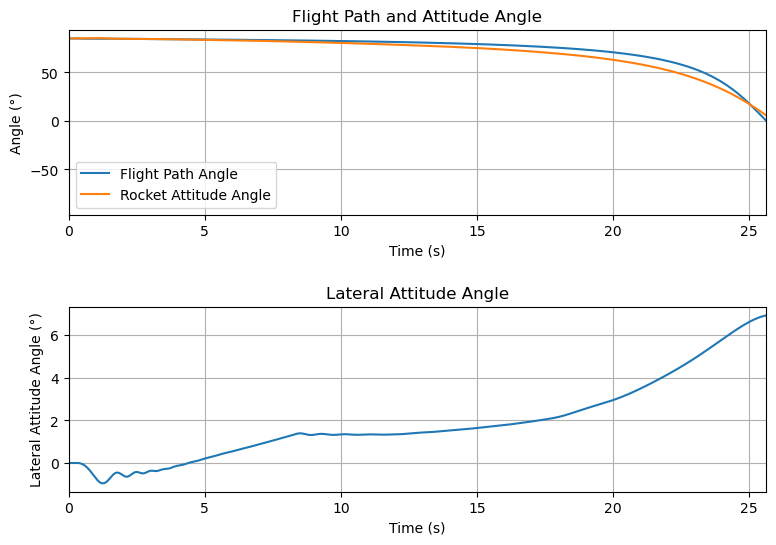



Path, Attitude and Lateral Attitude Angle plots



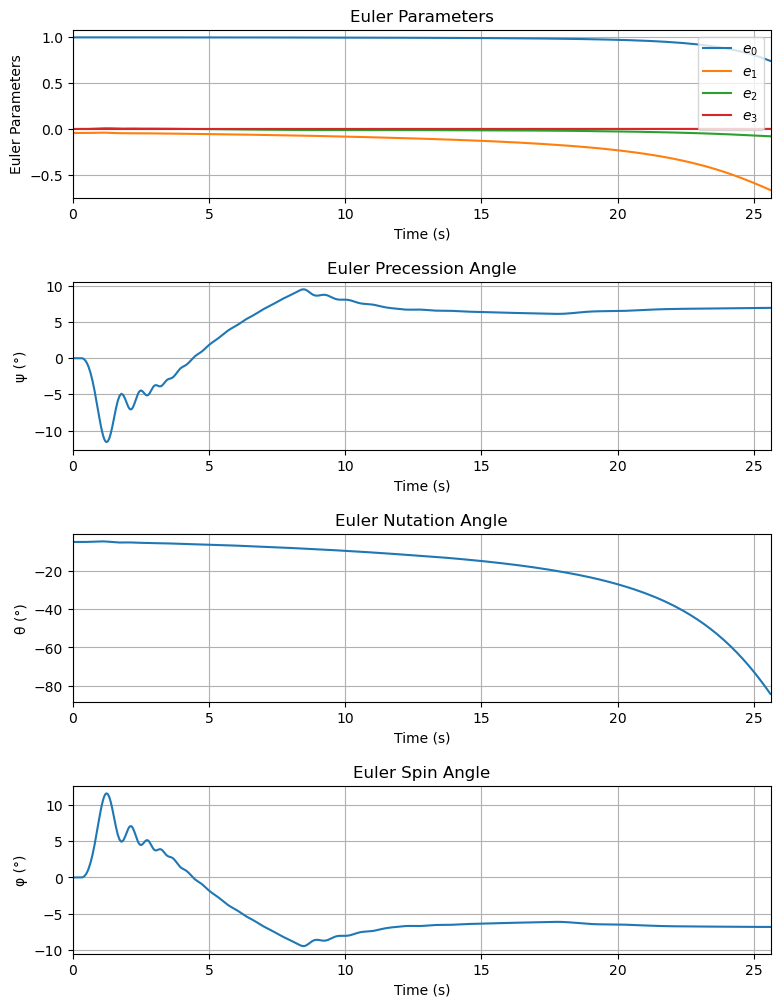



Trajectory Angular Velocity and Acceleration Plots



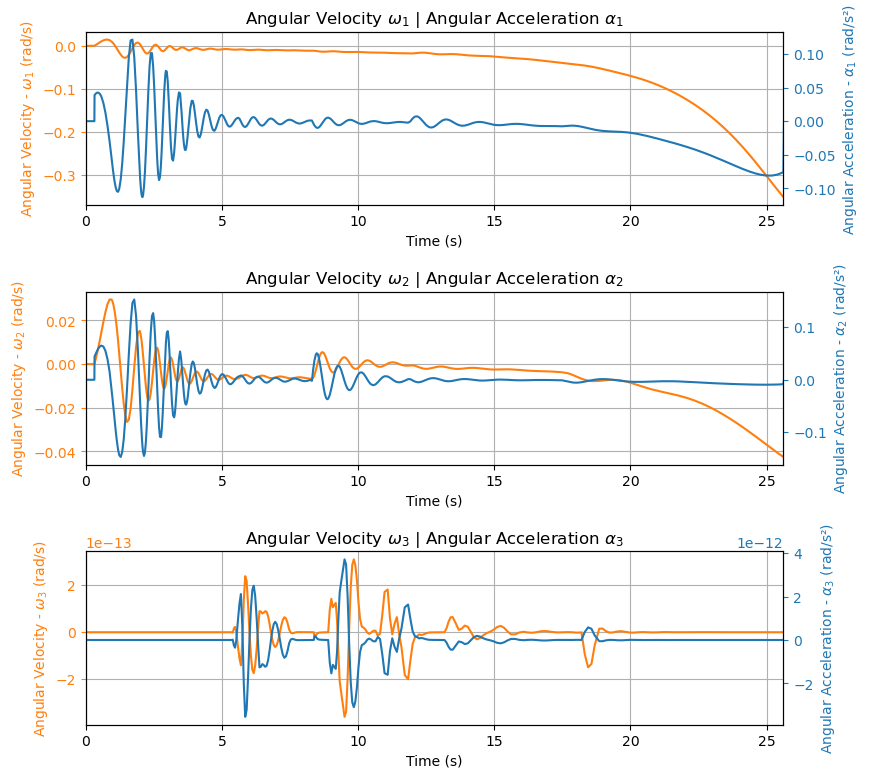



Aerodynamic Forces Plots



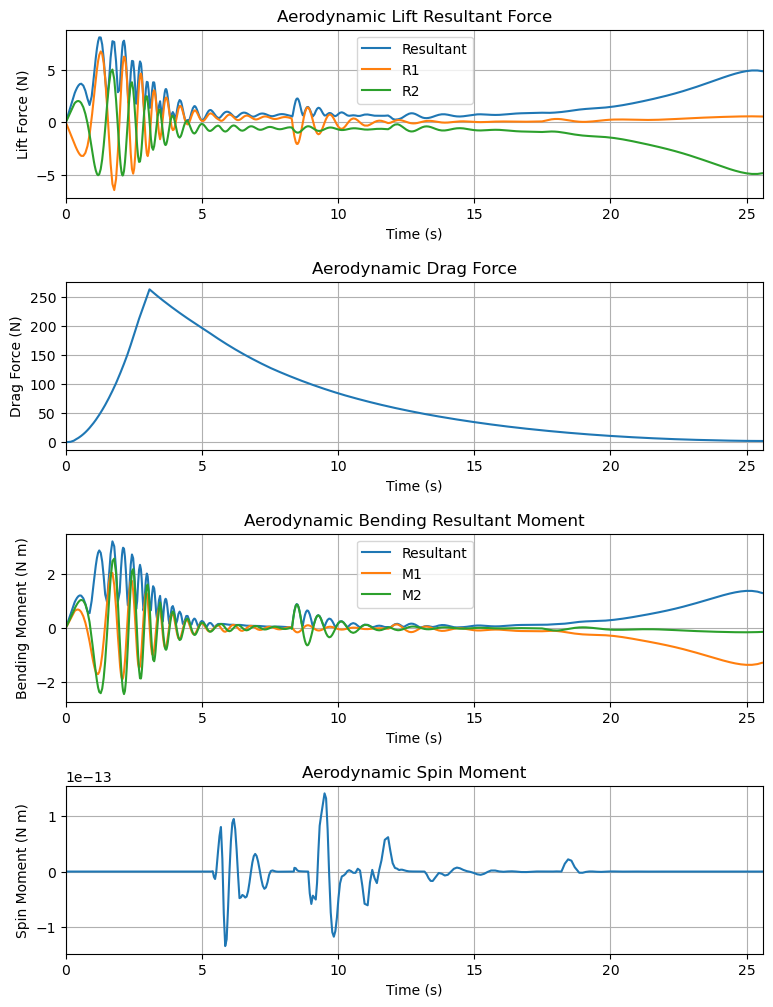



Rail Buttons Forces Plots



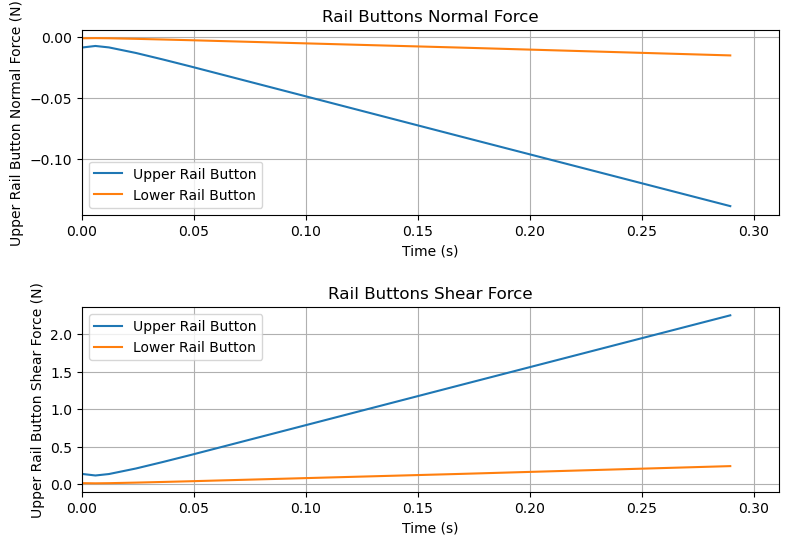



Trajectory Energy Plots



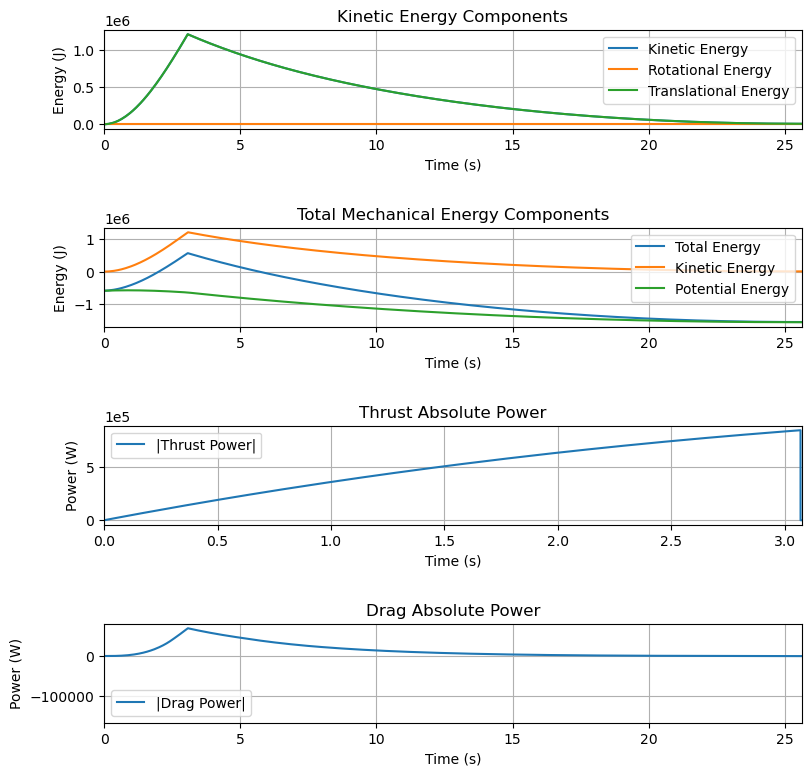



Trajectory Fluid Mechanics Plots



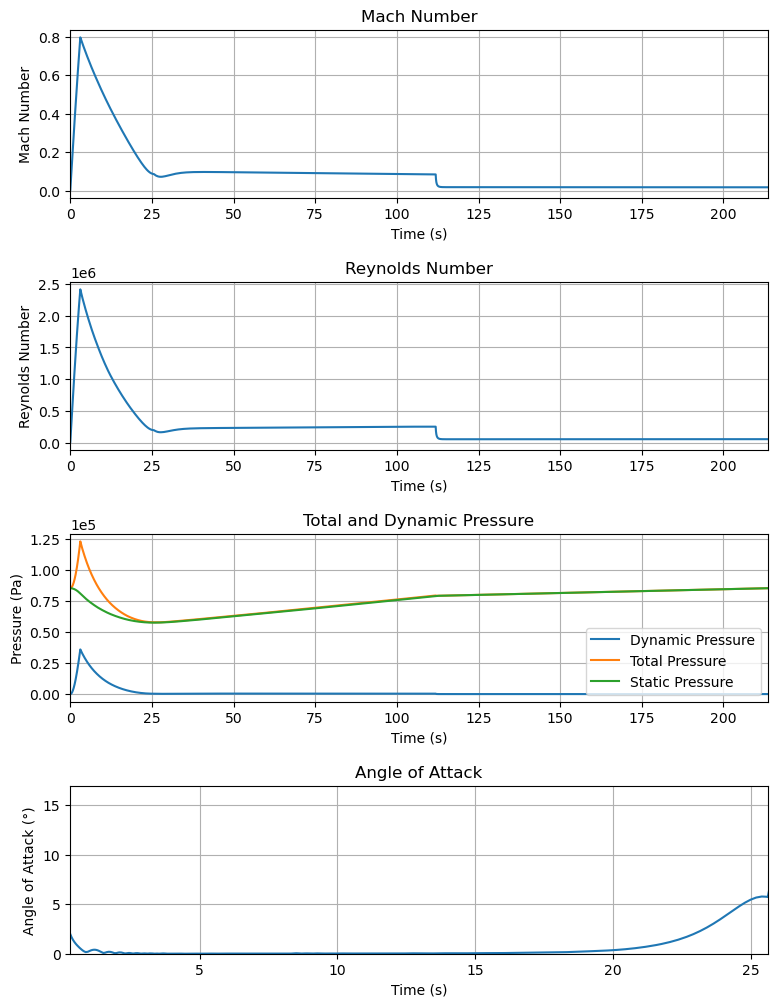



Trajectory Stability and Control Plots



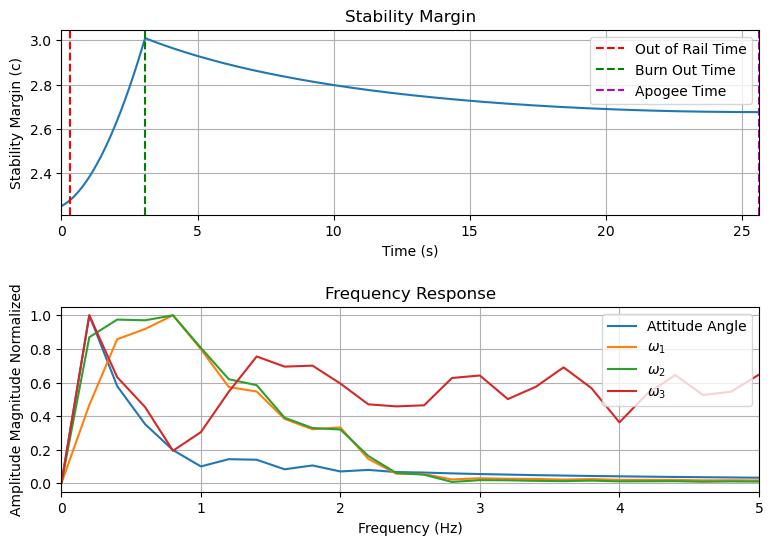



Rocket and Parachute Pressure Plots



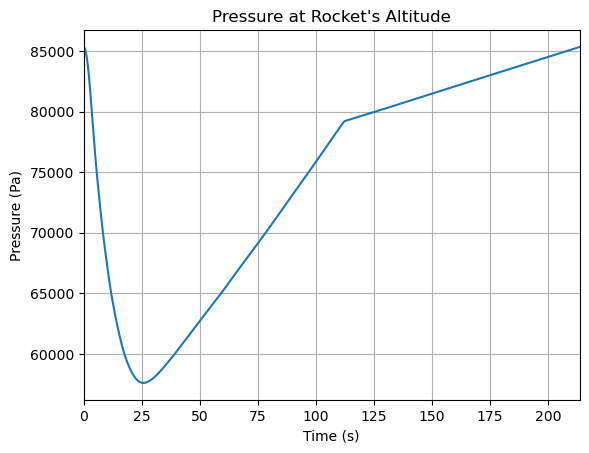


Parachute:  Drogue


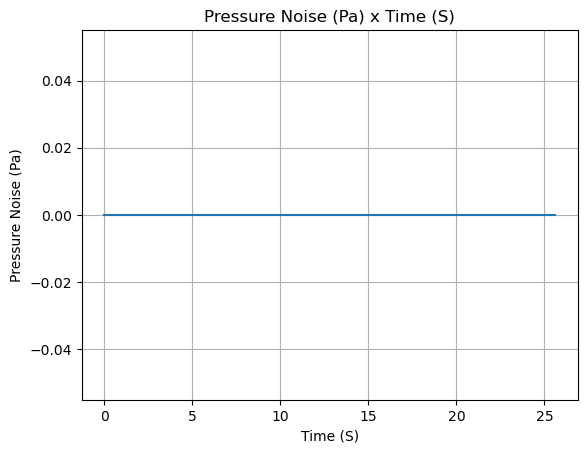

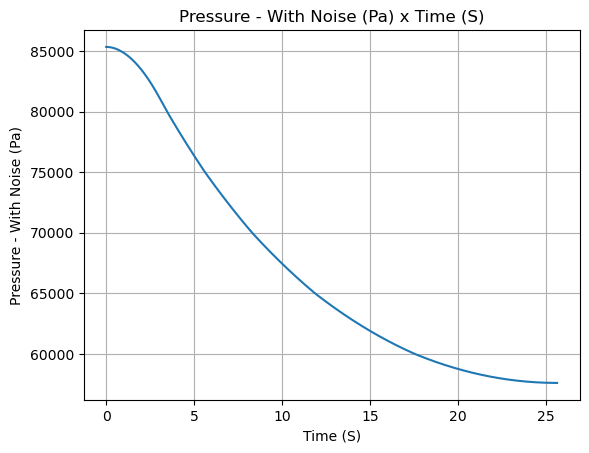

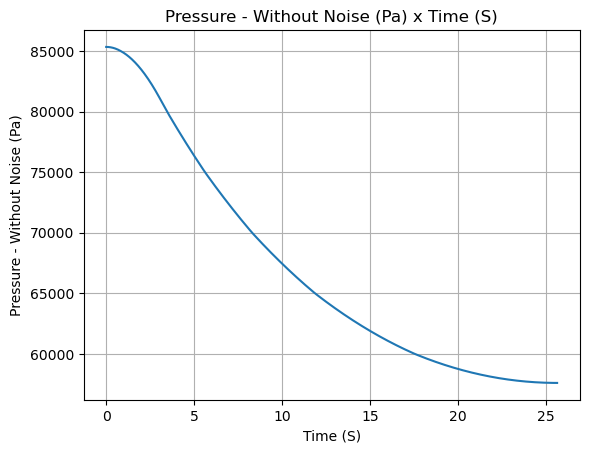


Parachute:  Main


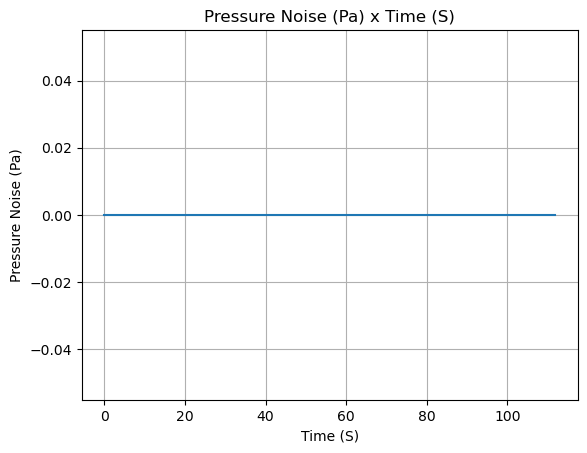

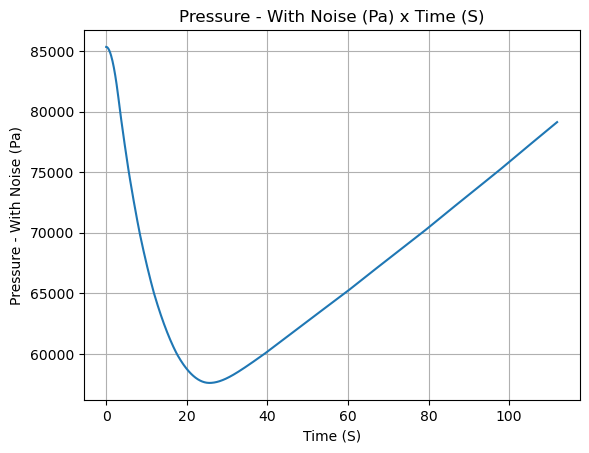

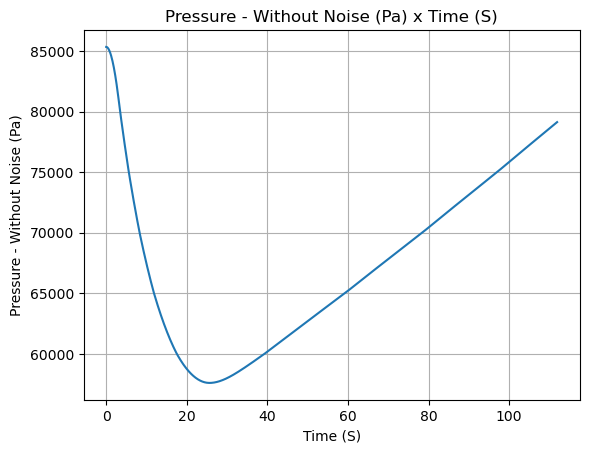

In [17]:
test_flight.all_info()

In [18]:
import numpy as np
import math

#DATA OUTPUT
dryMass = theRocket.mass + theEngine.dry_mass

#Solving Static_margin
timeSteps = np.linspace(0, timeRun, 100)
staticMarginOutputs = theRocket.static_margin(timeSteps)
maxStaticMargin = max(staticMarginOutputs)
minStaticMargin = min(staticMarginOutputs)

#Solving Average Thrust on Rail
timeRail = np.linspace(0, test_flight.out_of_rail_time, 100)
outputThrustOutputs = theEngine.thrust(timeRail)
outputRailMass = theRocket.total_mass(timeRail)
averageRailThrust = np.mean(outputThrustOutputs)
averageRailWeight = (np.mean(outputRailMass) * 9.81) #Keep in metric since thrust in newtons

#print(outputThrustOutputs)

#Seconds of each event
timeDrogueDeploy = (test_flight.parachute_events[0][0])
timeMainDeploy = (test_flight.parachute_events[1][0])
timeImpact = (test_flight.t_final)

#Solving Average Drogue Descent Speed
elements = 100
timeDrogue = np.linspace(timeDrogueDeploy, timeMainDeploy, elements)
outputDrogueDescentSpeed = (test_flight.vz(timeDrogue)) / (in2m * 12) #Convert to ft/s
averageDrogueDescentSpeed = np.average(outputDrogueDescentSpeed)
maxDrogueDescentSpeed = min(outputDrogueDescentSpeed) #min() called since we are dealing with negative floats
minDrogueDescentSpeed = max(outputDrogueDescentSpeed[5:elements-5]) #ignore first 5 elements

#Solving altitude main descent velocity brought under 30 ft/s
timeMain = np.linspace(timeMainDeploy, timeImpact, 100)
timeMainThreshold = False #Initializing to default if trigger never reached. This will describe the time the vehicle descent speed is below 30ft/s
#index all except last value just in case impact has weird effect
for t in timeMain[:-1]:
    descentSpeedImperial = test_flight.vz(t) / (in2m * 12)
    if descentSpeedImperial < 30:
        timeMainThreshold = t
        break
if timeMainThreshold:
    altitudeMainThreshold = (test_flight.z(timeMainThreshold) - env.elevation)/ (in2m * 12)
else:
    altitudeMainThreshold = "NEVER"
        
#Max Dynamic Pressure

#Output Data I Need
print("INPUTS")
print(f"Rocket Wet Mass: {theRocket.total_mass(0)} kg")
print(f"Rocket Dry Mass with Payload: {dryMass} kg")
print(f"Payload Mass: {massPayload} kg")
print(f"Ox Mass: {oxTank.liquid_mass(0)} kg")
print(f"Fuel Mass: {fuelTank.liquid_mass(0)} kg")
print(f"Rail or Tower Choice: {rail_lengthImperialFeet} ft")
print(f"Launch Angle: {launchAngle} degrees")
print(f"Main Trigger Altitude: {mainTriggerImperialFeet} ft")
print("")


print("OUTPUTS")
print(f"Apogee: {(test_flight.apogee - env.elevation) / (in2m * 12)} ft")
print(f"Total Impulse: {theEngine.total_impulse} Ns")
print(f"Estimated Burn Time: {theEngine.burn_duration} s")
print(f"Max Static Margin: {(maxStaticMargin)} cal")
print(f"Min Static Margin: {(minStaticMargin)} cal")
print(f"Max Velocity: {(test_flight.max_speed) / (in2m * 12)} ft/s")
print(f"Max Mach: {(test_flight.max_mach_number)}")
print(f"Average Thrust on Rail: {averageRailThrust} N")
print(f"Rail Exit Velocity: {(test_flight.out_of_rail_velocity) / (in2m * 12)} ft/s")
print(f"TTW on Rail: {averageRailThrust / averageRailWeight}")
print(f"Average Drogue Descent from Apogee: {averageDrogueDescentSpeed} ft/s")
print(f"Max Drogue Descent Speed from Apogee: {maxDrogueDescentSpeed} ft/s")
print(f"Min Drogue Descent Speed from Apogee: {minDrogueDescentSpeed} ft/s")
print(f"Altitude where descent < 30 ft/s: {altitudeMainThreshold} ft")
print(f"Ground Hit Velocity: {test_flight.impact_velocity/(in2m * 12)} ft/s")
print(f"Max Dynamic Pressure: {test_flight.max_dynamic_pressure} Pa")
print(theRocket.cp_position)
print(theRocket.center_of_mass(0))

INPUTS
Rocket Wet Mass: 40.91933551195521 kg
Rocket Dry Mass with Payload: 33.516128511955216 kg
Payload Mass: 3.401942775 kg
Ox Mass: 6.504800000000001 kg
Fuel Mass: 0.6404 kg
Rail or Tower Choice: 20 ft
Launch Angle: 5 degrees
Main Trigger Altitude: 2000 ft

OUTPUTS
Apogee: 10198.410673159688 ft
Total Impulse: 11417.250631492248 Ns
Estimated Burn Time: 3.075 s
Max Static Margin: 2.6723703840888438 cal
Min Static Margin: 2.25105578567198 cal
Max Velocity: 867.1617074218095 ft/s
Max Mach: 0.7967372961929784
Average Thrust on Rail: 4217.707964313104 N
Rail Exit Velocity: 96.19208393047782 ft/s
TTW on Rail: 10.596180621792435
Average Drogue Descent from Apogee: -94.8262969746882 ft/s
Max Drogue Descent Speed from Apogee: -201.85082497665186 ft/s
Min Drogue Descent Speed from Apogee: -71.02728540976071 ft/s
Altitude where descent < 30 ft/s: 1999.5139444336783 ft
Ground Hit Velocity: -19.159950255881192 ft/s
Max Dynamic Pressure: 36008.28042923902 Pa
Function from R1 to R1 : (x) → (Scalar)

In [19]:
#BENDING MOMENT CALCULATIONS
#Collect input variables:
CoP = theRocket.cp_position ((test_flight.max_mach_number)) #[m] from the bottom of the rocket
maxVelocity = (test_flight.max_speed)  #[m]
maxCrosswind = 16 #[m/s], tentatively. rocketpy may have a function for this
angleIronThickness = 0.003175 #[m]
angleIronWidth = 0.0254 #[m]
angleIronHeight = 1.4986 #[m]
angleIronArea = angleIronWidth**2 - (angleIronWidth-angleIronThickness)**2
angleIronAmount = 3 #[]
Cd = 1 #[], tentatively
#vehicle height is stored in heightVehicle, diameter is stored in diameter
tankThickness = .1625 * 0.0254 #[m]
thrustForce = 1000 * 4.44822 #[N]
maxAngle = 0.0872665 #[rad]
tankPressure = 1000 * 6894.76 #[Pa]
rho = 1.225 #[kg/m^3]
rocketDiam = diameter
aluminumModulus = 68*10**9 #[Pa]

#Calculate moments of inertia:
singleAngleIronMoI = (angleIronThickness)*(angleIronWidth)**3 / 3 + (angleIronWidth-angleIronThickness)*(angleIronThickness)**3 / 3 #[m^4]
totalAngleIronMoI = angleIronAmount * (singleAngleIronMoI + angleIronArea*(diameter/2)**2) #[m^4]
aluminumShellMoI = (math.pi / 64) * (rocketDiam**4 - (rocketDiam - 2*tankThickness)**4)#[m^4]
tankCrossSectionalArea = (math.pi / 4) * (rocketDiam**2 - (rocketDiam - 2*tankThickness)**2) #[m^2]

#Calculate the bending moment
totalWind = math.sin(maxAngle) * maxVelocity + maxCrosswind
profileAreaTop = (heightVehicle - CoP) * diameter #[m^2]
profileAreaBottom = CoP * diameter #[m^2]
forceWindTop = 0.5 * profileAreaTop * Cd * rho * totalWind**2 #[N]
forceWindBottom =  0.5 * profileAreaBottom * Cd * rho * totalWind**2 #[N]
forceWindTopDistance = (heightVehicle - CoP) / 2
forceWindBottomDistance = CoP / 2
bendingMoment = forceWindTop * forceWindTopDistance

#Calculating Buckling Load
bucklingConstant = 0.25 # held at bottom, unconstrained at top
aluminumBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * aluminumShellMoI / heightVehicle
angleIronBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * totalAngleIronMoI / angleIronHeight
singleAngleIronBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * singleAngleIronMoI / angleIronHeight
print("Buckling Load of entire vehicle: ", "{:.4f}".format(aluminumBucklingLoad), "N (", "{:.4f}".format(aluminumBucklingLoad*0.2248), "lbs )")
print("Buckling Load of", angleIronAmount, "angle irons: ", "{:.4f}".format(angleIronBucklingLoad), "N (", "{:.4f}".format(angleIronBucklingLoad*0.2248), "lbs )")
print("Buckling Load of single angle iron: ", "{:.4f}".format(singleAngleIronBucklingLoad), "N (", "{:.4f}".format(singleAngleIronBucklingLoad*0.2248), "lbs )")

#Calculating Bending Stresses:
tankBendingStress = bendingMoment * (rocketDiam/2) / aluminumShellMoI
angleIronBendingStress = bendingMoment * (rocketDiam/2 + angleIronWidth/2) / totalAngleIronMoI
print("Maximum bending stress in tank:", "{:.4f}".format(tankBendingStress/10**6), "MPa (", "{:.4f}".format(aluminumBucklingLoad/10**6 * 0.1450377377), "ksi )")
print("Maximum angle iron bending stress:", "{:.4f}".format(angleIronBendingStress/10**6), "MPa (", "{:.4f}".format(angleIronBendingStress/10**6 * 0.1450377377), "ksi )")

#Calculate Pressure Stresses:
p_o = 101352 #[Pa]
p_i = tankPressure #[Pa]
r_i = rocketDiam/2 - tankThickness #[m]
r_o = rocketDiam/2 #[m]
tankLongStress = (p_i*r_i**2 - p_o*r_o**2) / (r_o**2 - r_i**2) 
tankHoopStress = (p_i*r_i**2 - p_o*r_o**2) / (r_o**2 - r_i**2) - r_i**2 * r_o**2 * (p_o - p_i) / (r_o**2 * (r_o**2 - r_i**2))
print("Tank Longitudinal stress in tank:", "{:.4f}".format(tankLongStress/10**6), "MPa (", "{:.4f}".format((tankLongStress/10**6 * 0.1450377377)), "ksi )")
print("Tank Hoop Stress in tank:", "{:.4f}".format(tankHoopStress/10**6), "MPa (", "{:.4f}".format(tankHoopStress/10**6 * 0.1450377377), "ksi )")

# Compile pressure sum:
tankAxialStress = tankBendingStress + tankLongStress - thrustForce / tankCrossSectionalArea
#tankVonMises = math.sqrt(tankAxialStress**2 + tankHoopStress**2 - tankAxialStress*tankHoopStress)
#print("Resultant Von Mises Stress =", "{:.4f}".format(tankVonMises/10**6), "MPa (", "{:.4f}".format(tankVonMises/10**6 * 0.1450377377), "ksi )")

Buckling Load of entire vehicle:  291807.1536 N ( 65598.2481 lbs )
Buckling Load of 3 angle irons:  300803.4977 N ( 67620.6263 lbs )
Buckling Load of single angle iron:  1968.2668 N ( 442.4664 lbs )
Maximum bending stress in tank: 5.3410 MPa ( 0.0423 ksi )
Maximum angle iron bending stress: 12.2634 MPa ( 1.7787 ksi )
Tank Longitudinal stress in tank: 57.5593 MPa ( 8.3483 ksi )
Tank Hoop Stress in tank: 115.2199 MPa ( 16.7112 ksi )


In [40]:
# FIN FLUTTER EQUATIONS (https://apogeerockets.com/education/downloads/Newsletter291.pdf):

Cr = 9        # root chord [in]
Ct = 2.5      # tip chord [in]
span = 5.5    # span OR semi-span [in]
t = 0.125     # thickness [in]
G = 3900000   # shear modulus of material [psi]
h = 2311      # altitude of rocket at max velocity is hard to know so just calc for flutter speed at sea level for conservative estimate [ft]

T = 59 - (0.00356 * h)                                     # air temperature [deg F]
P = 2116 * ((T + 459.7) / 518.6)**5.256 / 144              # air pressure [lb/in^2]
a = math.sqrt(1.4 * 1716.59 * (T + 460))                   # speed of sound [ft/s]
S = ((Cr + Ct) * span / 2 )                                # area of the fin [in^2]
AR = span**2 / S                                           # aspect ratio [in]
lambdaVal = Ct / Cr                                        # tip to root ratio [--]

# Calculating critical flutter speed [ft/s], then finding it as Mach mutliple 
Vf = a * math.sqrt(G / (1.337 * AR**3 * P * (lambdaVal+1) / ((2 * (AR + 2) * (t/Cr)**3)))) 
VfMach = Vf / a

# inside sqrt: [lbs/in^2] / [in^3 * lb/in^2] / [in]

print("Root Chord:", Cr, "in")
print("Tip Chord:", Ct, "in")
print("Span:", span, "in")
print("Thickness:", t, "in")
print("Shear Modulus", G, "psi")
print("Altitude:", h, "ft above Sea Level of FAR OUT location")
print()
print("Air Temperature:", "{:.2f}".format(T), "deg F")
print("Air Pressure:", "{:.4f}".format(P), "psi")
print("Fin Area:", "{:.4f}".format(S), "in^2")
print("Fin Aspect Ratio:", "{:.3f}".format(AR), "in")
print("Lambda:", "{:.4f}".format(lambdaVal))
print("Speed of sound:", "{:.4f}".format(a), "ft/s")
print()
print("Critical Flutter Speed:", "{:.4f}".format(Vf), "ft/s ," , "{:.4f}".format(VfMach), "Mach")
print(f"Max Velocity: {(test_flight.max_speed) / (in2m * 12)} ft/s")
print(f"Factor of Safety: {Vf / ((test_flight.max_speed) / (in2m * 12))}")

Root Chord: 9 in
Tip Chord: 2.5 in
Span: 5.5 in
Thickness: 0.125 in
Shear Modulus 3900000 psi
Altitude: 2311 ft above Sea Level of FAR OUT location

Air Temperature: 50.77 deg F
Air Pressure: 13.5238 psi
Fin Area: 31.6250 in^2
Fin Aspect Ratio: 0.957 in
Lambda: 0.2778
Speed of sound: 1107.9271 ft/s

Critical Flutter Speed: 1936.7155 ft/s , 1.7481 Mach
Max Velocity: 867.1617074218095 ft/s
Factor of Safety: 2.2333959823250966
